In [1]:
import torch

if torch.cuda.get_device_capability() < (7, 5):
  raise ValueError(f"You got a GPU with capability {torch.cuda.get_device_capability()}, need at least (7, 5)")
else: print("OK")

OK


In [2]:
%pip install -q bitsandbytes==0.37.0 transformers==4.27.4 datasets==2.7.0 accelerate==0.18.0 loralib==0.1.1 peft==0.3.0.dev0

Note: you may need to restart the kernel to use updated packages.


#### Load model

In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import torch.nn.functional as F
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
from accelerate import init_empty_weights, infer_auto_device_map

CACHE_DIR = '/media/tfsservices/DATA/NLP/cache/'
MODEL_NAME = "EleutherAI/gpt-neox-20B"
# MODEL_NAME = "gpt2-large"
# MODEL_NAME = "facebook/opt-30b"


config = AutoConfig.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
with init_empty_weights():
    model = AutoModelForCausalLM.from_config(config)



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# device_map = infer_auto_device_map(model, dtype="float16")

In [5]:
# print(device_map)

In [6]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    load_in_8bit=True,        # bitsandbytes lib required (convert the loaded model into mixed-8bit quantized model.)
    device_map='auto',
    # device_map=device_map,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR)      # path to a directory in which a downloaded pretrained model
    # low_cpu_mem_usage=True,   # loads the model using ~1x model size CPU memory
    # offload_state_dict=True)  # temporarily offload the CPU state dict to the hard drive to avoid getting out of CPU RAM
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


#### Post-processing on the model

In [7]:
# model.eval()

In [8]:
# for module in model.modules():
#     if isinstance(module, bnb.nn.Linear8bitLt):
#         module.state.memory_efficient_backward = True

for param in model.parameters():
    param.requires_grad = False  # freeze the model - train adapters later
    if param.ndim == 1:
        param.data = param.data.to(torch.float32) # cast the small parameters (e.g. layernorm) to fp32 for stability

model.gradient_checkpointing_enable()  # reduce number of stored activations
# model.gpt_neox.project_in = lambda x: x.requires_grad_(True)
model.enable_input_require_grads()

# cast model outputs to float32 to unfuck the top-k sampler
class CastOutputToFloat(nn.Sequential):
    def forward(self, x): return super().forward(x).to(torch.float32)
model.embed_out = CastOutputToFloat(model.embed_out)
# model.lm_head = CastOutputToFloat(model.lm_head)

#### Apply LoRA

In [9]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [10]:
from peft import LoraConfig, get_peft_model 

config = LoraConfig(
    r=8, ## can be reduced to 8
    lora_alpha=32,
    target_modules=["query_key_value" ],
    # target_modules=["c_attn" ],
    # target_modules=["k_proj", "v_proj", "q_proj" ],
    lora_dropout=0.05, ## 0.05
    bias="none",
    task_type="CAUSAL_LM",
    inference_mode=False # test,
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 8650752 || all params: 20563218432 || trainable%: 0.04206905659543013


In [11]:
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTNeoXForCausalLM(
      (gpt_neox): GPTNeoXModel(
        (embed_in): Embedding(50432, 6144)
        (layers): ModuleList(
          (0-43): 44 x GPTNeoXLayer(
            (input_layernorm): LayerNorm((6144,), eps=1e-05, elementwise_affine=True)
            (post_attention_layernorm): LayerNorm((6144,), eps=1e-05, elementwise_affine=True)
            (attention): GPTNeoXAttention(
              (rotary_emb): RotaryEmbedding()
              (query_key_value): MergedLinear8bitLt(
                in_features=6144, out_features=18432, bias=True
                (lora_dropout): Dropout(p=0.05, inplace=False)
                (lora_A): Linear(in_features=6144, out_features=16, bias=False)
                (lora_B): Conv1d(16, 12288, kernel_size=(1,), stride=(1,), groups=2, bias=False)
              )
              (dense): Linear8bitLt(in_features=6144, out_features=6144, bias=True)
            )
            (mlp): GPTNeoXMLP(
    

#### Fine-tune model

#### Prepare dataset

In [12]:
# from datasets import load_dataset

# dataset = load_dataset("csv", data_files="./datasets/armm.csv")['train']

In [13]:
import pandas as pd

df = pd.read_csv('datasets/armm_large_01.csv')
# df = pd.read_csv('datasets/wm_large_01.csv')


# df = pd.read_csv('datasets/armm_small.csv')
# df = pd.read_csv('datasets/wm.csv')
# df = pd.read_csv('datasets/wm_large.csv')

# CATEGORY = 'Purchase Inquiry'
# CATEGORY = 'Listing Inquiry'

# CATEGORY = 'Requirement'
CATEGORY = 'Listing'
df = df[df['tag']==CATEGORY]

# ADAPTER_NAME = "adapters/gpt-neox-20B-wm_list_resp_sm"

df.head()

,text,tag
0,"{Client},\r\n\r\nI wanted to show you the belo...",Listing
1,"{Client},\r\n\r\nWe've got the below {Category...",Listing
2,"{Client},\r\n\r\nOne of my clients is releasin...",Listing
3,"{Client},\r\n\r\nOur client is releasing {Qty}...",Listing
4,"Dear {Client},\r\n\r\nGood day. Hope you are d...",Listing


In [14]:
df['tokens'] = [len(t.split()) for t in df['text']]

In [15]:
# MIN_TOKENS_COUNT = 100
# df = df[df['tokens']>MIN_TOKENS_COUNT]

In [16]:
df.head()

,text,tag,tokens
0,"{Client},\r\n\r\nI wanted to show you the belo...",Listing,78
1,"{Client},\r\n\r\nWe've got the below {Category...",Listing,75
2,"{Client},\r\n\r\nOne of my clients is releasin...",Listing,54
3,"{Client},\r\n\r\nOur client is releasing {Qty}...",Listing,83
4,"Dear {Client},\r\n\r\nGood day. Hope you are d...",Listing,118


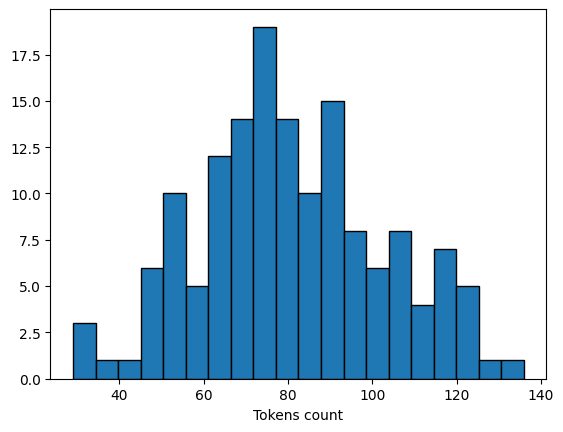

In [17]:
import matplotlib.pyplot as plt

plt.hist(df['tokens'], edgecolor='black', bins=20)
plt.xlabel('Tokens count')
plt.show()

In [18]:
df['prices'] = [t.count('{Price}') for t in df['text']]
print(f"Texts with prices: {round(len(df[df['prices']>0])/df['prices'].count()*100, 2)} %")

Texts with prices: 62.0 %


In [19]:
df['equip_details'] = [t.count('{EquipDetails}') for t in df['text']]
print(f"Texts with equipment details: {round(len(df[df['equip_details']>0])/df['equip_details'].count()*100, 2)} %")


Texts with equipment details: 98.0 %


In [20]:
df['questions'] = [t.count('?') for t in df['text']]
print(f"Texts with questions: {round(len(df[df['questions']>0])/df['questions'].count()*100, 2)} %")

Texts with questions: 11.33 %


In [21]:
df['make_models'] = [t.count('{MakeModel}') for t in df['text']]
print(f"Texts with mentioned Make/Models: {round(len(df[df['make_models']>0])/df['make_models'].count()*100, 2)} %")

Texts with mentioned Make/Models: 82.67 %


In [22]:
# def create_prompt_column(raw):

#     prompt = f"Generate text in {raw['tokens']} tokens for {raw['tag']}"

#     if (raw['prices'] > 0):
#         prompt += " with price"

#     if (raw['questions'] > 0):
#         prompt += " with questions"

#     prompt += f":\n{raw['text']}\n\n###\n"

#     return prompt

def create_prompt_column(raw):

    # return f"Q: Generate for {raw['tag']}:\nA: {raw['text']}\n###\n"
    # return f"Q: Generate response\nA: {raw['text']}\n###\n"
    return f"Q: Generate\nA: {raw['text']}\n###\n"

In [23]:
df['prompt'] = df.apply(create_prompt_column, axis=1)

In [24]:
df.head()

,text,tag,tokens,prices,equip_details,questions,make_models,prompt
0,"{Client},\r\n\r\nI wanted to show you the belo...",Listing,78,0,1,0,0,"Q: Generate\nA: {Client},\r\n\r\nI wanted to s..."
1,"{Client},\r\n\r\nWe've got the below {Category...",Listing,75,0,1,0,0,"Q: Generate\nA: {Client},\r\n\r\nWe've got the..."
2,"{Client},\r\n\r\nOne of my clients is releasin...",Listing,54,1,1,0,1,"Q: Generate\nA: {Client},\r\n\r\nOne of my cli..."
3,"{Client},\r\n\r\nOur client is releasing {Qty}...",Listing,83,1,1,0,0,"Q: Generate\nA: {Client},\r\n\r\nOur client is..."
4,"Dear {Client},\r\n\r\nGood day. Hope you are d...",Listing,118,1,1,0,1,"Q: Generate\nA: Dear {Client},\r\n\r\nGood day..."


In [25]:
# dataset_path = './datasets/wm_ext.csv'
dataset_path = './datasets/armm_ext.csv'
df.to_csv(dataset_path)

In [26]:
from datasets import load_dataset

# dataset_path = './datasets/wm_ext.csv'

dataset = load_dataset("csv", data_files=dataset_path)
tokenizer.pad_token = tokenizer.eos_token

dataset = dataset.map(lambda samples: tokenizer(samples['prompt']), batched=True)

# ADAPTER_NAME = "adapters/gpt-neox-20B-wm_purch_resp"
# ADAPTER_NAME = "adapters/gpt-neox-20B-wm_list_resp_small"


Using custom data configuration default-42280294f32be399


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1494.76it/s]
Generating train split: 0 examples [00:00, ? examples/s]/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:714: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Dataset csv downloaded and prepared to /home/tfsservices/.cache/huggingface/datasets/csv/default-42280294f32be399/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 25.50ba/s]


In [27]:
import transformers
from transformers import Trainer, DataCollatorForLanguageModeling, TrainingArguments

trainer = Trainer(
    model=model, 
    train_dataset=dataset['train'],
    args=TrainingArguments(
        per_device_train_batch_size=4, 
        gradient_accumulation_steps=4,
        # per_device_train_batch_size=1, 
        # gradient_accumulation_steps=1,
        warmup_steps=10, 
        # warmup_steps=2, 
        # max_steps=20, 
        # max_steps=10, 
        # max_steps=43, ## for large dataset
        max_steps=40, 
        # max_steps=50, 
        learning_rate=2e-4, 
        fp16=True,
        logging_steps=5, 
        # save_steps=100,
        output_dir='outputs_wm'),
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False))

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/transformers/models/gpt_neox/modeling_gpt_neox.p

Step,Training Loss
5,3.147000
10,2.861200
15,2.253400
20,1.911100
25,1.802400
30,1.728600
35,1.647300


TrainOutput(global_step=40, training_loss=2.1270639657974244, metrics={'train_runtime': 440.5628, 'train_samples_per_second': 1.453, 'train_steps_per_second': 0.091, 'total_flos': 1.2426897193648128e+16, 'train_loss': 2.1270639657974244, 'epoch': 4.21})

#### Save LoRA adapter

In [45]:
# ADAPTER_NAME = "lora_adapters-6.7b"
# ADAPTER_NAME = "lora_adapters-13b"
# ADAPTER_NAME = "adapters/gpt-j-6B-armm"
# ADAPTER_NAME = "adapters/gpt-j-6B-wm"

# ADAPTER_NAME = "adapters/gpt-neox-20B-armm_req_fix"
ADAPTER_NAME = "adapters/gpt-neox-20B-armm_list_fix"

# ADAPTER_NAME = "adapters/gpt-neox-20B-wm_purch_resp_fix"
# ADAPTER_NAME = "adapters/gpt-neox-20B-wm_list_resp_fix"

model.save_pretrained(ADAPTER_NAME)

#### Test generation

In [28]:
model.inference_mode=True
model.config.use_cache = False

In [29]:
def generate_marketing(max_length = 150):
    
    batch = tokenizer("Q: Generate\nA: ", return_tensors='pt').to('cuda')

    # with torch.no_grad():
    with torch.cuda.amp.autocast():
        output_tokens = model.generate(**batch, min_length=30, max_length=max_length, do_sample=True, pad_token_id=tokenizer.eos_token_id)

    print('\n\n', tokenizer.decode(output_tokens[0].cpu().numpy()))

In [30]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):

    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = stops
        self.ENCOUNTERS = encounters

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        stop_count = 0
        for stop in self.stops:
            stop_count = (stop == input_ids[0]).sum().item()

        if stop_count >= self.ENCOUNTERS:
            return True
        return False    

stop_words_ids = [tokenizer(stop_word, return_tensors='pt')['input_ids'].squeeze() for stop_word in ["###"]]
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids, encounters=1)])

In [38]:
def generate(prompt: str, max_length=250):

    batch = tokenizer(prompt, return_tensors="pt").to('cuda')

    # input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    # with torch.no_grad():
    with torch.cuda.amp.autocast():
        # outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_length=max_length, do_sample=True, )
        outputs = model.generate(**batch,
                                # early_stopping=True, 
                                # num_beams=6,
                                # num_beam_groups = 3,
                                # no_repeat_ngram_size = 4,
                                # temperature=0.9,
                                top_k=10,
                                # top_p=0.8,
                                # penalty_alpha=0.6,
                                # repetition_penalty = 1.05,
                                do_sample=True,

                                max_length = max_length,
                                pad_token_id=tokenizer.eos_token_id,
                                stopping_criteria=stopping_criteria,
                                
                                # use_cachе=True,
                                # output_scores=True,
                                # return_dict_in_generate=True).detach()
        )
        generated = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0]
        print(f"tokens: {len(generated.split())}")
        print(f"text: {generated}")

In [39]:
# generate(prompt='Q: Generate Requirement \nA:', max_length=250)
# generate(prompt='Q: Generate response\nA:', max_length=512)
generate(prompt='Q: Generate\nA:', max_length=512)
# generate(prompt='Q: Generate text  \nA:', max_length=250)
# generate_marketing()
# generate(prompt='Hi {Client}:', max_length=250)

tokens: 99
text: Q: Generate
A: {Client},

I'm reaching out to you to see if you have a need for {MakeModel} at any price. 

This unit has been in a warehouse environment for a long time and has recently been cleaned out. 

There are some parts that are still there and working but I wanted to make sure you are aware and have a chance to evaluate this before the seller puts it out.

{EquipDetails}

Please let me know if you have any interest or if you are looking for anything else and let me know your timelines.

Best regards,

{Signature}
###


In [40]:
# generate(prompt='Q: Generate Requirement \nA:', max_length=250)
# generate(prompt='Generate text in 150 tokens for Purchase Inquiry with questions:', max_length=250)
# generate(prompt='Q: Generate response\nA:',max_length=512)
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 47
text: Q: Generate
A: {Client} 

Our Client is selling the following:

{MakeModel} 

We're releasing it because we're moving into a new space and this machine is no longer needed.

We expect this to be gone in the next couple weeks.

Asking price is {Price}

{EquipDetails}

Best,

{Signature}
###


In [41]:
# generate(prompt='Q: Generate Listing \nA:', max_length=450)
# generate(prompt='Generate text for Purchase Inquiry :', max_length=250)
# generate(prompt='Q: Generate response\nA:', max_length=512)
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 116
text: Q: Generate
A: Dear {Client},
Hope all is well. We are interested in selling a used {MakeModel} {Category}. The machine is complete, but we will be releasing it to a new owner as we need to reduce our space.

This particular machine is in good condition, it has been used by a client for some time and is only being sold to generate some space for us.

Here are the detailed specs of this unit:

{EquipDetails}

Please review our link to see detailed photos of the system {EquipPhotos}

We would like to receive your best offers ASAP, please let me know if you have any interest or would like to have a chat.

Regards,

{Signature}
###


In [42]:
# generate(prompt='Q: Generate response\nA:', max_length=512)
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 37
text: Q: Generate
A: Hi {Client},

I have a used {MakeModel} {Category} for sale. 

Please review the pictures and let me know if you are interested so that I can get the details from seller.

Regards,

{Signature}
###


In [43]:
# generate(prompt="Q: Generate response\nA:", max_length=512)
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 50
text: Q: Generate
A: Hi {Client},

We have just released a {MakeModel} {Category}, which is only {Qty} pieces left. You can see the link to the {Details} for further details below.

{EquipDetails}

Please let me know ASAP if this is a match, and if you are interested in this.

{Signature}
###


In [44]:
# generate(prompt="Q: Generate response\nA:", max_length=512)
generate(prompt="Q: Generate\nA:", max_length=512)

tokens: 37
text: Q: Generate
A: Hi {Client},

We have the following {MakeModel} available for sale at {Price}. 

Please review the following details and let me know if you are interested, or we can make further arrangement. 

{EquipDetails}

{Signature}
###


In [77]:
# generate(prompt="Dear {FirstName} ", max_length=250)
# generate(prompt='Q: Generate for Purchase Inquiry \nA:', max_length=250)

In [78]:
# generate(prompt="Q: Generate for New Listing \nA:", max_length=250)

In [79]:
# generate(prompt="Requirement: Hi {FirstName} ", max_length=200)
# generate(prompt="Requirement: ", max_length=200)
# generate(prompt="Hi {FirstName} ", max_length=250)
# generate(prompt="Q: Generate for Purchase Inquiry \nA: ", max_length=450)

In [80]:
# generate(prompt="Q: Generate for New Listing \nA:", max_length=250)

In [81]:
# generate(prompt="Inquiry: Hi {FirstName} ", max_length=200)